In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os

In [2]:
rows = []
with open("fuel_cell_data.csv", 'r') as f:
    csvreader = csv.reader(f)
    for row in csvreader:
        rows.append(row)

In [3]:
# rows

In [4]:
len(rows)

221841

In [5]:
rows_ = rows
rows = rows[1:] 

In [6]:
rows = np.array(rows, dtype = np.float32)
rows.shape

(221840, 16)

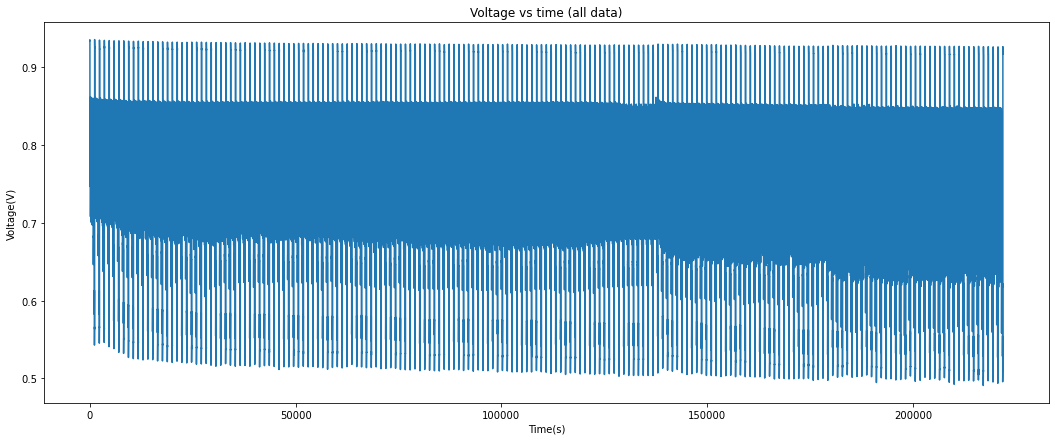

In [70]:
plt.figure(figsize = (18,7))
plt.plot(rows[:,1])
plt.xlabel("Time(s)")
plt.ylabel("Voltage(V)")
plt.title("Voltage vs time (all data)");

In [108]:
voltage = rows[rows[:,0]==0,1]
voltage2= voltage[voltage<0.9]

voltage = voltage[voltage>0.9]
timesteps2 = range (1, len(voltage2)+1,1)
timesteps = range(1,len(voltage)+1,1)

In [109]:
print(f"No. of observation when current value is zero: {len(voltage) }  {len(voltage2) }")

No. of observation when current value is zero: 6461  13


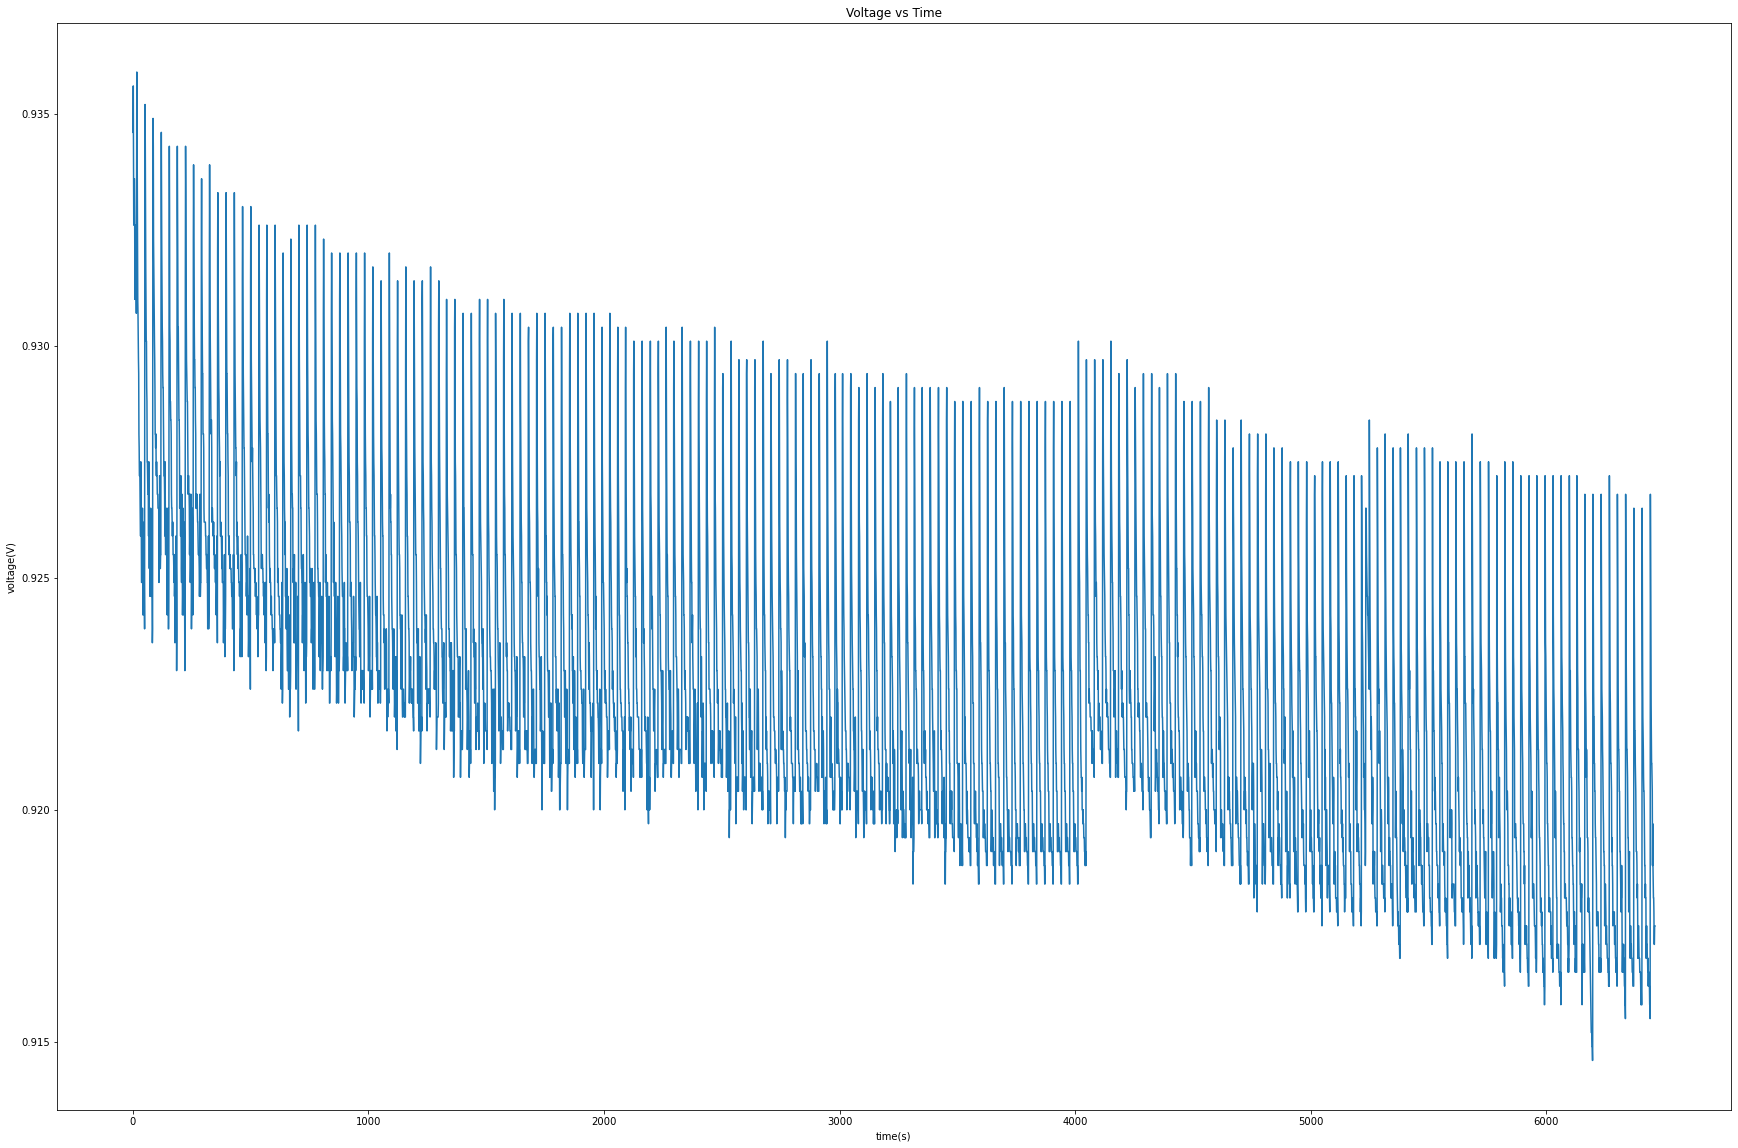

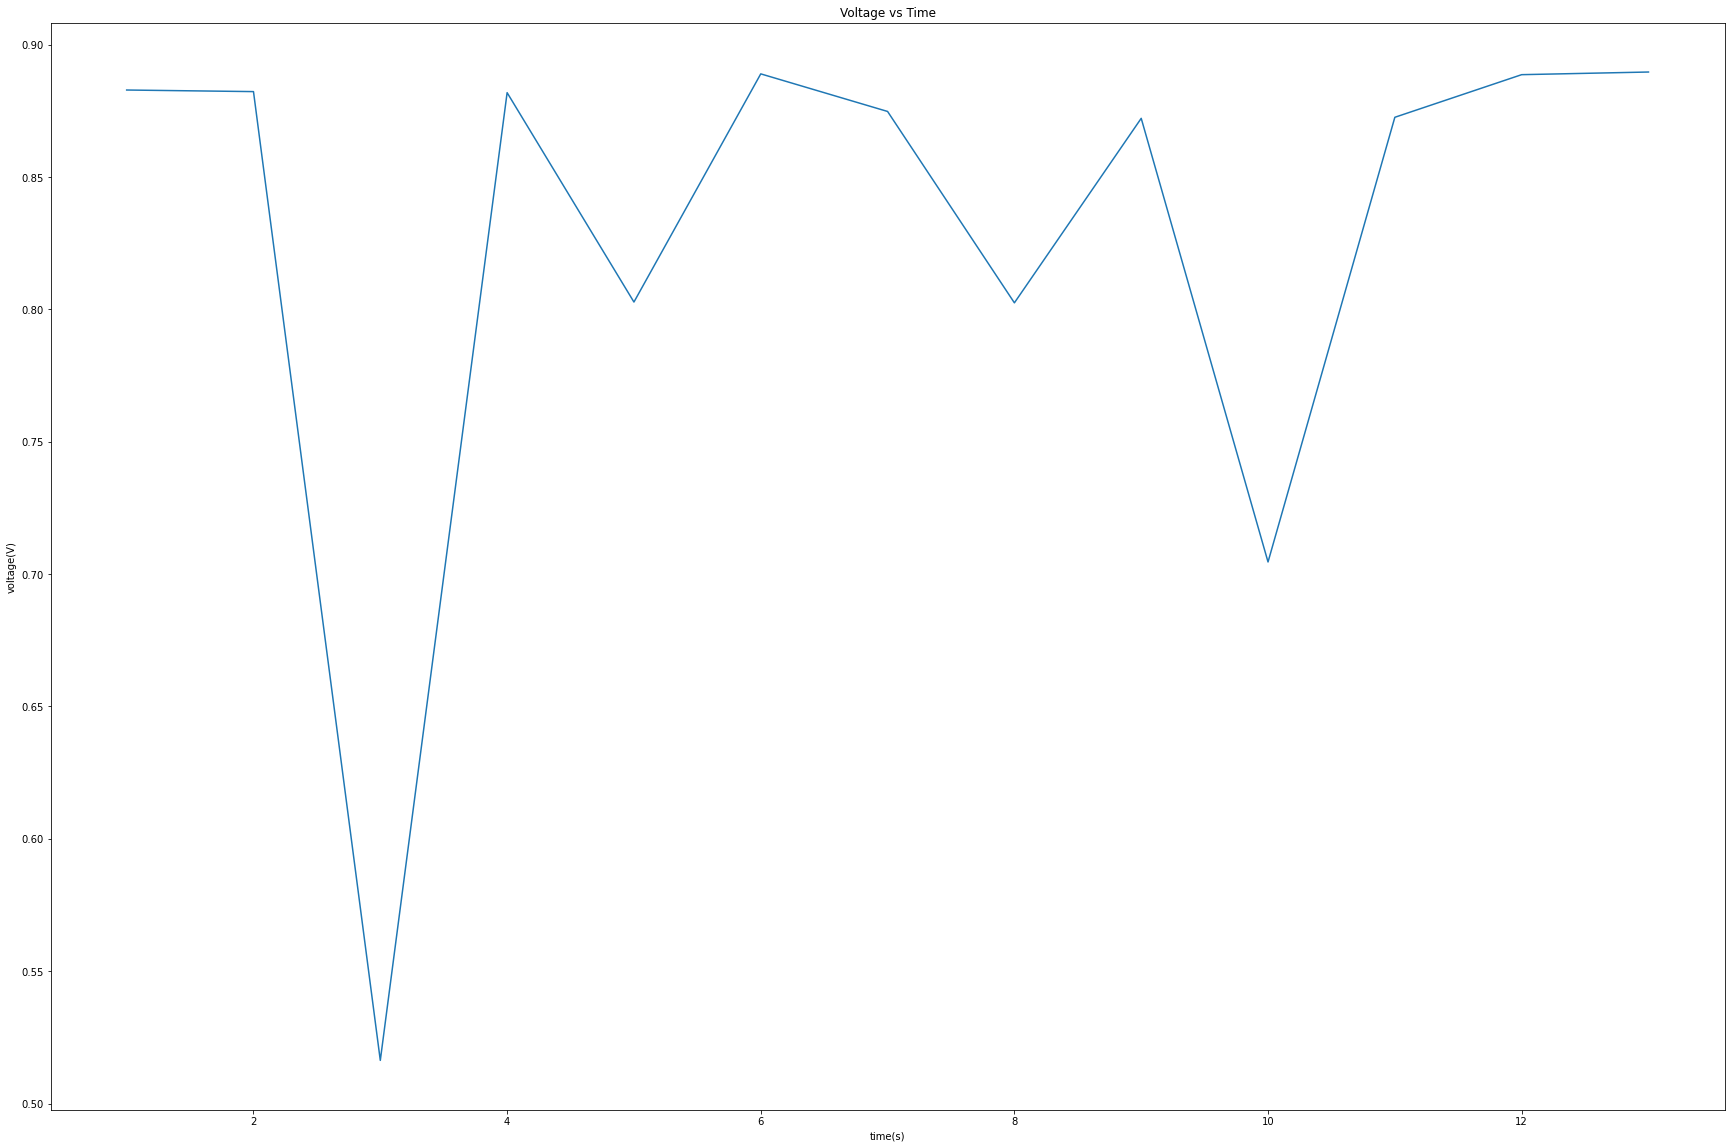

In [116]:
plt.figure(figsize = (30,12))
plt.plot(timesteps,voltage)
#plt.plot(timesteps2, voltage2)
plt.xlabel("time(s)")
plt.ylabel("voltage(V)")
plt.title("Voltage vs Time for High Voltage");

plt.figure(figsize = (30,12))
plt.plot(timesteps2, voltage2)
plt.xlabel("time(s)")
plt.ylabel("voltage(V)")
plt.title("Voltage vs Time for low voltage");

In [117]:
voltage_cleared = voltage[voltage>0.9]
timesteps_cleared = range(1,len(voltage_cleared)+1,1)

In [77]:
print(f"No. of observation (noise removed) when current value is zero: {len(voltage_cleared)}")

No. of observation (noise removed) when current value is zero: 0


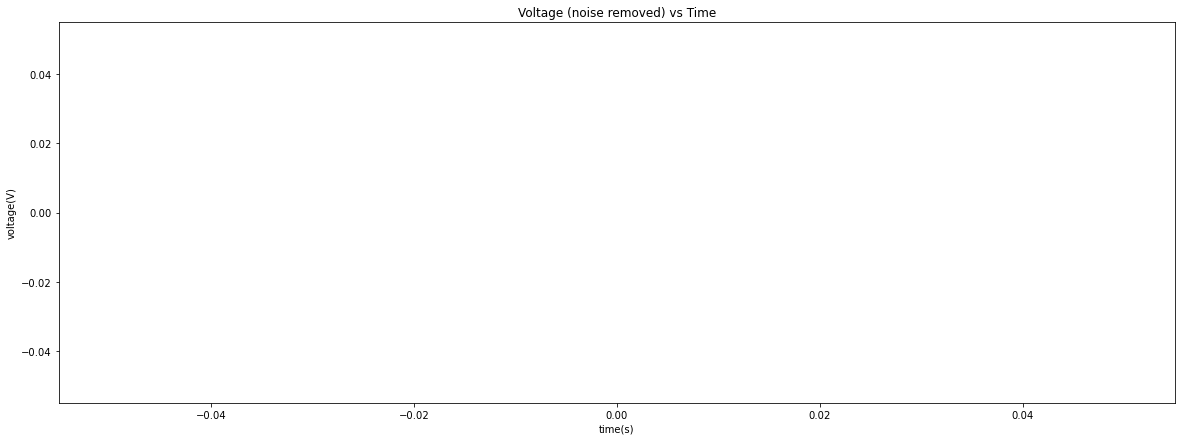

In [78]:
plt.figure(figsize = (20,7))
plt.plot(timesteps_cleared, voltage_cleared)
plt.xlabel("time(s)")
plt.ylabel("voltage(V)")
plt.title("Voltage (noise removed) vs Time");

#Here onward, we will work on cleared (noise i.e., extreme values removed) voltage values. The cleared voltage data has 6461 observations.

In [79]:
# Create train and test splits the right way for time series data
# split_size = int(0.8 * len(voltage)) # 80% train, 20% test
split_size = 6000

# Create train data splits (everything before the split)
# X_train, y_train = timesteps[:split_size], voltage[:split_size]
X_train, y_train = timesteps_cleared[:split_size], voltage_cleared[:split_size]

# Create test data splits (everything beyond the split)
# X_test, y_test = timesteps[split_size:], voltage[split_size:]
X_test, y_test = timesteps_cleared[split_size:], voltage_cleared[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(0, 0, 0, 0)

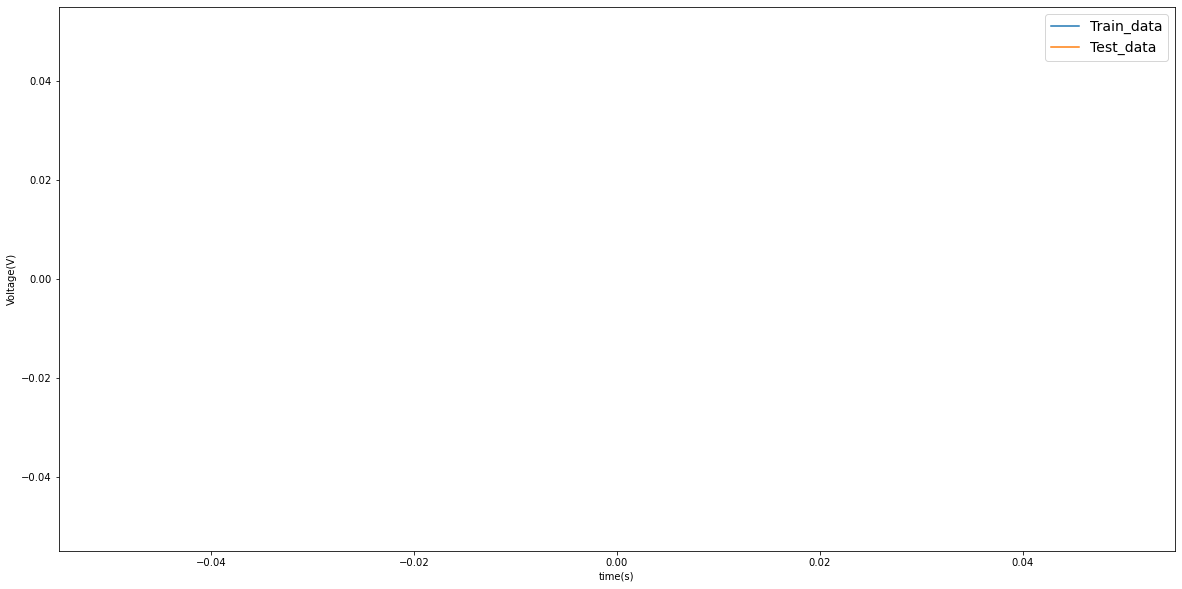

In [80]:
# Plot splits
plt.figure(figsize=(20, 10))
plt.plot(X_train, y_train, label = "Train_data")
plt.plot(X_test, y_test, label = "Test_data")
plt.xlabel("time(s)")
plt.ylabel("Voltage(V)")
plt.legend(fontsize=14)
plt.show();

In [30]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time(s)")
  plt.ylabel("Voltage(V)")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [31]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [32]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [33]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 value
WINDOW_SIZE = 7 # use the past 7 voltage value

In [34]:
# Create function to label windowed data
def get_labelled_windows(x, horizon = HORIZON):

  return x[:, :-horizon], x[:, -horizon:]

In [35]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon=HORIZON):
  """
  Turn a 1D array into a 2D array of sequential labelled windows of  window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis = 0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis = 0).T # create 2D array of window
  
  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [64]:
# full_windows, full_labels = make_windows(voltage)
full_windows, full_labels = make_windows(voltage_cleared)
len(full_windows), len(full_labels)

(6454, 6454)

In [65]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split = 0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  # split_size = int(len(windows) * (1-test_split))
  split_size = 6000
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [66]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(6000, 454, 6000, 454)

In [67]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "model_experiments"):

  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            verbose = 0,
                                            save_best_only = True)

In [68]:
def make_preds(model, input_data):
  
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array

In [69]:
tf.random.set_seed(42)

# Let's build an LSTM model with the functional API
inputs = layers.Input(shape = (WINDOW_SIZE))
x =layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation = "relu", return_sequences = True)(x)
x = layers.LSTM(128, activation = "relu")(x)
x = layers.Dense(32, activation = 'relu')(x)
output = layers.Dense(HORIZON)(x)
model = tf.keras.Model(inputs = inputs, outputs = output, name = "model_LSTM")

# Compile
model.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit
model.fit(train_windows,
            train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model.name)])

Epoch 1/100
44/47 [===========================>..] - ETA: 0s - loss: 0.7108INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 7s 88ms/step - loss: 0.6710 - val_loss: 0.1448
Epoch 2/100
43/47 [==========================>...] - ETA: 0s - loss: 0.0359INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 81ms/step - loss: 0.0332 - val_loss: 0.0042
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.0049INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 92ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0075
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 6/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 7/100
45/47 [===========================>..] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 83ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 8/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 9/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 10/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 11/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 12/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 13/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0074
Epoch 14/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 15/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 16/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 17/100
4

INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 87ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 20/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0078
Epoch 21/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 22/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 23/100
43/47 [==========================>...] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 78ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 24/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 25/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 26/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 27/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 28/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 29/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 30/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 31/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 32/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0060 - val_loss: 0.0092
Epoch 33/100

INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 92ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 48/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 49/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 50/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 51/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 52/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 53/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 54/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 55/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 56/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 57/100

INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 91ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 67/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 68/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 69/100
47/47 [==============================] - 1s 16ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 70/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 71/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 72/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 73/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 74/100
46/47 [============================>.] - ETA: 0s - loss: 0.0022INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 87ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 75/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 76/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 77/100
46/47 [============================>.] - ETA: 0s - loss: 0.0052INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 5s 100ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 78/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 79/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 80/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 81/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0148
Epoch 82/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 83/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 84/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 85/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 86/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 87/1

INFO:tensorflow:Assets written to: model_experiments/model_LSTM/assets


47/47 [==============================] - 4s 95ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 98/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0134
Epoch 99/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 100/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0013


In [70]:
# Load in best version of model and evaluate on the test data
model = tf.keras.models.load_model("model_experiments/model_LSTM")
model.evaluate(test_windows, test_labels)

15/15 [==============================] - 0s 3ms/step - loss: 0.0013


0.0012726716231554747

In [71]:
# Make prediction with our LSTM model
model_preds = make_preds(model, test_windows)

In [72]:
# Evaluate model 5 predictions
model_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_preds)
model_results

{'mae': 0.0012726724,
 'mse': 6.447734e-06,
 'rmse': 0.002539239,
 'mape': 0.13792986,
 'mase': 1.7555358}

In [73]:
model_preds_train = make_preds(model, train_windows)

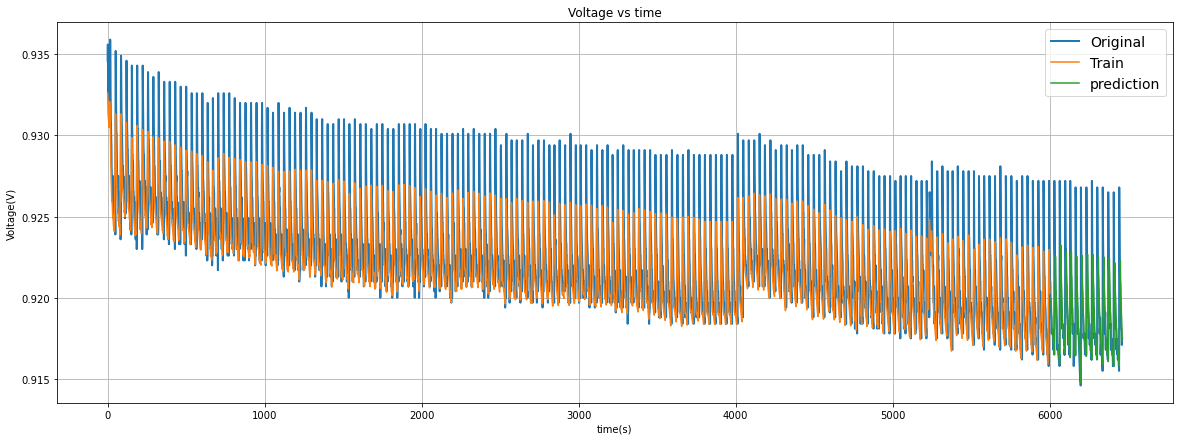

In [74]:
plt.figure(figsize=(20, 7))
# plt.plot(timesteps, voltage, linewidth=2.0, label = "Original")
plt.plot(timesteps_cleared, voltage_cleared, linewidth=2.0, label = "Original")
plot_time_series(timesteps = X_train[-len(train_windows):], 
                 values = model_preds_train, 
                 start = 0, 
                 format = '-', 
                 label = "Train")
plot_time_series(timesteps = X_test[-len(test_windows):], 
                 values = model_preds, 
                 start = 0, 
                 format = '-',
                 label = "prediction")
plt.xlabel("time(s)")
plt.ylabel("Voltage(V)")
plt.legend(fontsize=14)
plt.title("Voltage vs time")
plt.show();

In [75]:
def forecasting(N, last_window):
  forecast = []
  last_window = last_window.numpy()
  for _ in range(N):
    window = np.expand_dims(last_window, axis=0)
    forecast_val = make_preds(model, np.expand_dims(last_window, axis=0))
    forecast.append(forecast_val)
    last_window = np.delete(last_window, 0)
    last_window = np.append(last_window, forecast_val)
  
  return forecast

In [76]:
future_predictions = 2000
N = future_predictions - len(test_windows)
preds = forecasting(N, model_preds[-7:])

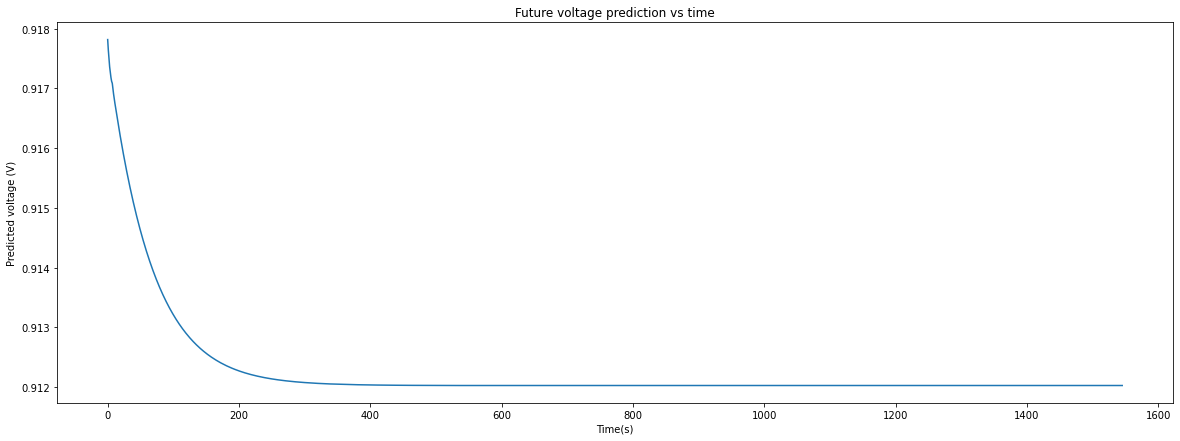

In [77]:
plt.figure(figsize = (20,7))
plt.plot(preds, label = "predicted")
plt.xlabel("Time(s)")
plt.ylabel("Predicted voltage (V)")
plt.title("Future voltage prediction vs time");

In [78]:
pred_vals = model_preds.numpy()
preds_ = np.array(preds)
pred_vals = np.append(pred_vals, preds_)

In [79]:
len(pred_vals)

2000

In [80]:
# To see particular instance's value
# instance = 2000
# print(pred_vals[instance-1])

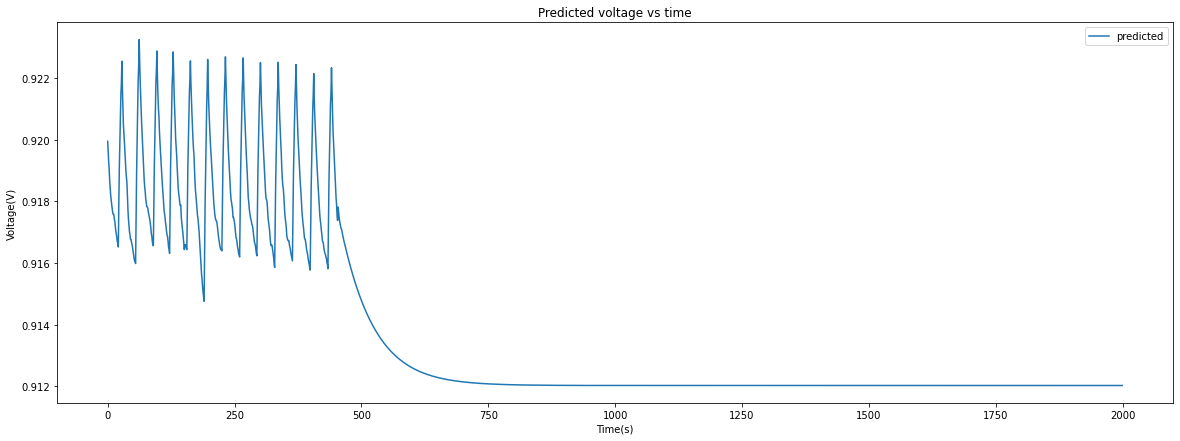

In [81]:
plt.figure(figsize=(20, 7))
plt.plot(pred_vals, label = "predicted")
plt.xlabel("Time(s)")
plt.ylabel("Voltage(V)")
plt.legend()
plt.title("Predicted voltage vs time");

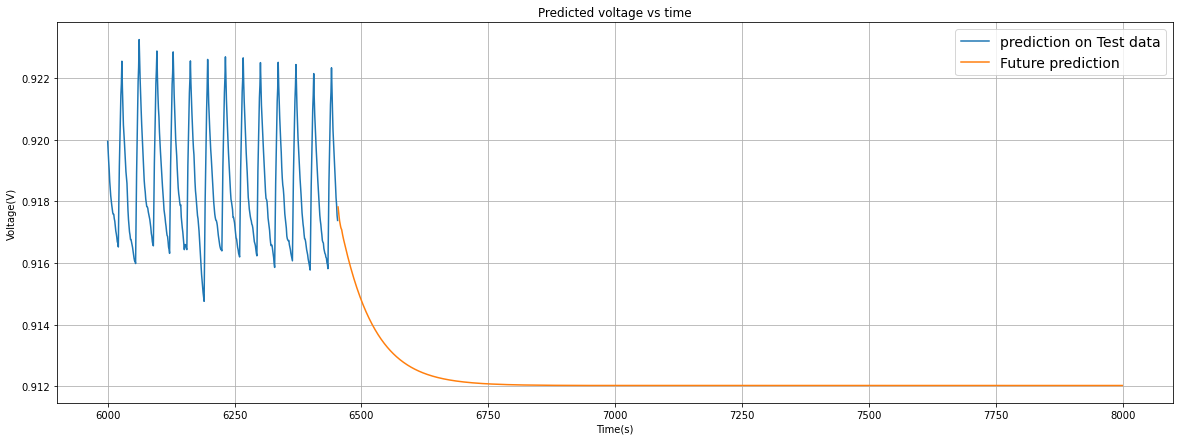

In [82]:
plt.figure(figsize=(20, 7))
plot_time_series(timesteps = range(len(train_windows),len(train_windows)+len(model_preds)), 
                 values = model_preds, 
                 start = 0, 
                 format = '-',
                 label = "prediction on Test data")
plot_time_series(timesteps = range(len(train_windows)+len(model_preds), len(train_windows)+len(model_preds)+len(pred_vals)-len(test_windows)), 
                 values = preds_, 
                 start = 0, 
                 format = '-', 
                 label = "Future prediction")
plt.title("Predicted voltage vs time");

In [83]:
pred_vals = []
diff = []
for i, window in enumerate(test_windows):
  pred_val = make_preds(model, np.expand_dims(window, axis=0))
  error = abs(pred_val-test_labels[i])
  pred_vals.append(pred_val)
  diff.append(error)

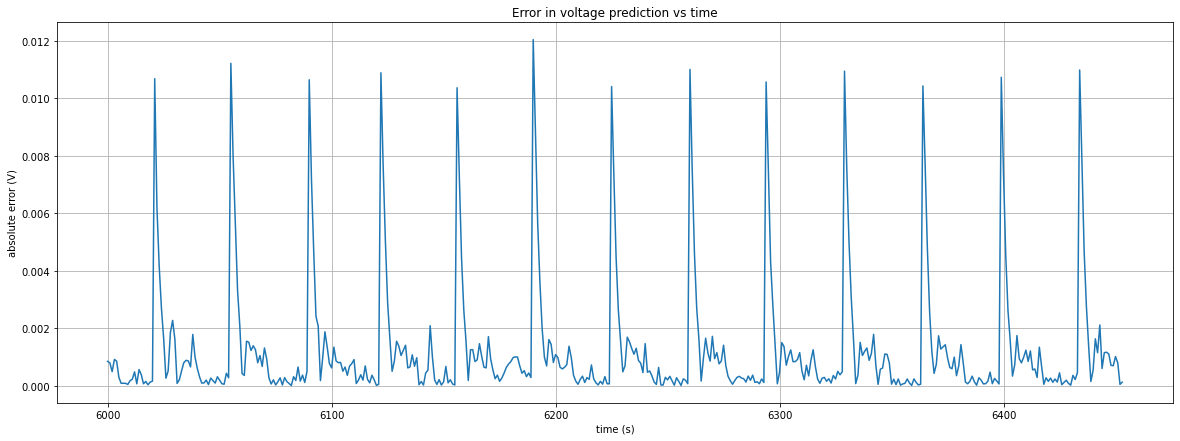

In [84]:
plt.figure(figsize = (20,7))
timesteps = range(len(train_windows),len(train_windows)+len(model_preds))
plt.plot(timesteps, diff)
plt.xlabel("time (s)")
plt.ylabel("absolute error (V)")
plt.grid(True)
plt.title("Error in voltage prediction vs time");